# Predicción del precio de las acciones de Bancolombia en la Bvc

## Introducción

El objetivo de este proyecto es elaborar generar y un modelo que permita predecir el precio de las acciones de BANCOLOMBIA en la bolsa de valores de Colombia (Precio cierre).

Para este fin, se descargaron los valores históricos de precio de cierre diario y sus indicadores asociados desde el 17 de enero de 2008 hasta el 16 de marzo de 2019 (aproximadamente 10 años). 

Datos históricos de precios de acciones en la Bvc: https://www.bvc.com.co/pps/tibco/portalbvc/Home/Empresas/Listado+de+Emisores

Tomando como guía un trabajo de predicción de precios de acciones de Goldman Sachs (NYSE: GS), decidimos incluir distintos datos de entrada: datos de precio de cierre de acciones de varias empresas del sector financiero colombiano, indicadores técnicos calculados a partir del precio de cierre de las acciones de Bancolombia, Transformadas de Fourier para extraer direcciones de tendencias generales, información de un modelo ARIMA e indicadores asociados al comportamiento de la economía en colombia (COLCAP). 

Todo esto, con el fin de contar con la mayor cantidad de datos posible para la realización de buenas predicciones.

Link de interés: https://github.com/borisbanushev/stockpredictionai

A continuación, se presenta un resumen de las 31 características incluidas en nuestro dataset:

![alt text](./images/resumen.jpg "Resumen de características incluidas")

Análogamente, se muestran las empresas del sector financiero colombiano que no fueron incluidas en el análisis, por problemas de antiguedad o disponibilidad de los datos:

![alt text](./images/finan.jpg "Empresas del sector financiero en la Bvc")

## Contenido

#### 1. Carga inicial de los datos
#### 2. Procesamiento inicial de los datos históricos de Bancolombia
#### 3. Procesamiento de datos COLCAP
#### 4. Precio de cierre de empresas del sector
#### 5. Indicadores técnicos de los datos de Bancolombia
#### 6. Transformada de Fourier
#### 7. ARIMA

## 1. Carga inicial de los datos

Inicialmente, se cargan la mayoría de librerías que se usarán a lo largo del notebook:

In [1]:
%matplotlib inline

In [2]:
from pandas import read_csv
from datetime import datetime
from pandas import read_csv
from matplotlib import pyplot
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import pandas as pd
import zipfile
import numpy as np

Instalación de librería para procesar archivos de excel con pandas.

In [3]:
!pip install xlrd

You are using pip version 9.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


Los datos históricos descargados de la Bvc, están organizados archivos Excel que comprenden un semestre cada uno. En total, cada empresa tiene 23 archivos de excel que deberan ser procesados, analizados y unificados en un solo dataset. A continuación, se cargan los datos y se descomprimen en la carpeta "data":

In [4]:
!wget -P './data/' -nc https://www.dropbox.com/s/j8mnh2y5qmxbrra/data.zip
!unzip "./data/data.zip"

--2019-06-02 22:04:59--  https://www.dropbox.com/s/j8mnh2y5qmxbrra/data.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.1, 2620:100:601d:1::a27d:501
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/j8mnh2y5qmxbrra/data.zip [following]
--2019-06-02 22:04:59--  https://www.dropbox.com/s/raw/j8mnh2y5qmxbrra/data.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc7f4ca5f4ea25e7422a8675ec75.dl.dropboxusercontent.com/cd/0/inline/AiHPRaSHoeXOsYN92qapNxGnSlBsobtnOW7dIQWQd7MxOm7d56DUg8CkZ1w79DdDGdqbKY5fl99QLkvuHzm4O26ynrsK9v5yXL9-eNyqInFgMQ/file# [following]
--2019-06-02 22:05:00--  https://uc7f4ca5f4ea25e7422a8675ec75.dl.dropboxusercontent.com/cd/0/inline/AiHPRaSHoeXOsYN92qapNxGnSlBsobtnOW7dIQWQd7MxOm7d56DUg8CkZ1w79DdDGdqbKY5fl99QLkvuHzm4O26ynrsK9v5yXL9-eNyqInFgMQ/file
Resolving uc7f4ca5f4ea25e7422a8

Para procesar los 23 archivos de Excel de cada empresa, se define la siguiente función:

In [5]:
def load_data_company(path, file_company):
    file_zip = zipfile.ZipFile(path + file_company, 'r')
    files = file_zip.namelist() 
    print files
    dataframe = pd.DataFrame()
    for i in range(len(files)):
        filename = files[i];
        print 'Read file '+filename
        file_data = file_zip.open(filename)
        dataframe_tmp = pd.read_excel(file_data)
        dataframe = pd.concat([dataframe,dataframe_tmp])
        file_data.close()
    return dataframe

## 2. Procesamiento inicial de los datos históricos de Bancolombia

Procedemos a crear una lista con los nombres de las carpetas comprimidas y a procesar los datos históricos de Banconlombia:

In [6]:
company=['BCOLOMBIA','BOGOTA','OCCIDENTE','POPULAR','BBVACOL','BVC','PROTECCION']

In [7]:
path = './data/'
file_company = company[0]+'.zip'
dataframe = load_data_company(path, file_company)
dataframe = dataframe.drop(dataframe.columns[[0]], axis=1)
dataframe = dataframe.sort_values('fecha')

['3.xls.xls', '4.xls.xls', '5.xls.xls', '6.xls.xls', '7.xls.xls', '8.xls.xls', '9.xls.xls', '10.xls.xls', '11.xls.xls', '12.xls.xls', '13.xls.xls', '14.xls.xls', '15.xls.xls', '16.xls.xls', '17.xls.xls', '18.xls.xls', '19.xls.xls', '20.xls.xls', '21.xls.xls', '22.xls.xls', '23.xls.xls', '1.xls.xls', '2.xls.xls']
Read file 3.xls.xls
Read file 4.xls.xls
Read file 5.xls.xls
Read file 6.xls.xls
Read file 7.xls.xls
Read file 8.xls.xls
Read file 9.xls.xls
Read file 10.xls.xls
Read file 11.xls.xls
Read file 12.xls.xls
Read file 13.xls.xls
Read file 14.xls.xls
Read file 15.xls.xls
Read file 16.xls.xls
Read file 17.xls.xls
Read file 18.xls.xls
Read file 19.xls.xls
Read file 20.xls.xls
Read file 21.xls.xls
Read file 22.xls.xls
Read file 23.xls.xls
Read file 1.xls.xls
Read file 2.xls.xls


In [8]:
dataframe

,Nemotecnico,fecha,Cantidad,Volumen,Precio Cierre,Precio Mayor,Precio Medio,Precio Menor,Variacion%,Variacion Absoluta
0,BCOLOMBIA,2008-01-17,451725,6708441780,14600,15060,14850.7206,14600,-2.67,-400
1,BCOLOMBIA,2008-01-18,333726,4831369460,14100,14740,14477.0544,14100,-3.42,-500
2,BCOLOMBIA,2008-01-21,517380,6748778840,13040,13200,13044.1433,13040,-7.52,-1060
3,BCOLOMBIA,2008-01-22,886518,11979103280,13600,14200,13512.5325,12420,4.29,560
4,BCOLOMBIA,2008-01-23,355748,4933362960,13900,14160,13867.5775,13100,2.21,300
5,BCOLOMBIA,2008-01-24,396916,5781997880,14740,14740,14567.3086,14400,6.04,840
6,BCOLOMBIA,2008-01-25,341845,5142644400,15040,15220,15043.7900,14860,2.04,300
7,BCOLOMBIA,2008-01-28,353054,5284271860,15080,15260,14967.3191,14500,0.27,40
8,BCOLOMBIA,2008-01-29,410359,6270901640,15200,15340,15281.5014,15160,0.80,120
9,BCOLOMBIA,2008-01-30,242406,3641014260,15100,15160,15020.3141,14900,-0.66,-100


In [9]:
dataset=dataframe[["Cantidad","Volumen","Precio Cierre","Precio Mayor","Precio Medio","Precio Medio","Precio Menor","Variacion%","Variacion Absoluta"]]
data=dataset.values
data.shape

(2761, 9)

A continuación, se observa el comportamiento del "Precio de cierre" de las acciones de Bancolombia y las 7 características asociadas.

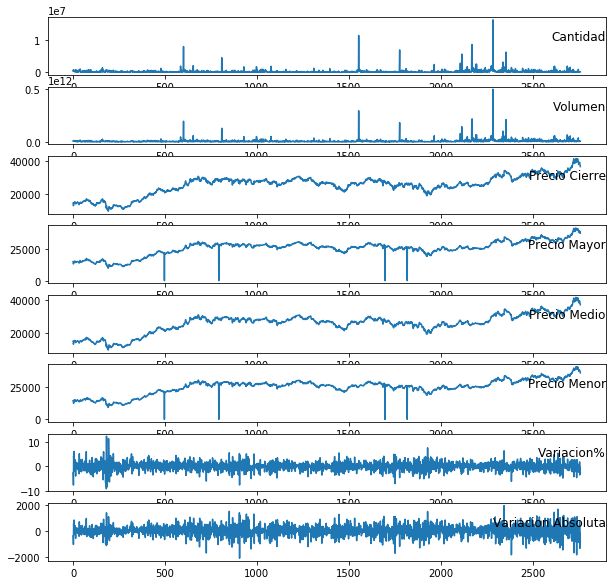

In [10]:
from pandas import read_csv
from matplotlib import pyplot
values = data
groups = [0, 1, 2, 3, 5, 6, 7,8]
i = 1
pyplot.figure(figsize=(10,10))
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

## 3. Procesamiento de datos COLCAP

El COLCAP es uno de los índices bursátiles de la BVC o Bolsa de Valores de Colombia, este indicador refleja las variaciones de los precios de las 20 acciones más líquidas donde el valor de Capitalización Bursátil ajustada de cada compañía determina su participación dentro de dicho índice. El primer cálculo se realizo el 15 de Enero de 2008.

En general, este índice nos permitirá asociar el precio de las acciones de Bancolombia con el comportamiento de las acciones más representativas en cada periodo de tiempo.

In [11]:
path = './data/'
file_company = 'COLCAP.zip'
df2 = load_data_company(path, file_company)
df2 = df2.drop(df2.columns[[2,3,4,5,6]], axis=1)
df2 = df2.sort_values('Fecha')
df2

['COLCAP.xlsx']
Read file COLCAP.xlsx


,Fecha,Ultimo
2759,2008-01-17,928.38
2758,2008-01-18,903.49
2757,2008-01-21,832.37
2756,2008-01-22,879.67
2755,2008-01-23,890.89
2754,2008-01-24,933.79
2753,2008-01-25,939.61
2752,2008-01-28,930.97
2751,2008-01-29,946.51
2750,2008-01-30,936.55


La información de COLCAP es cruzada con la información de bancolombia con ayuda de la comparación de los campos de fecha:

In [12]:
temp=pd.merge(dataframe, df2, how='right', left_on=['fecha'], right_on=['Fecha']).sort_values('fecha')
temp=temp.drop(temp.index[[-1,-2]], axis=0)
temp=temp.drop(temp.columns[[-2]], axis=1)
temp.rename(columns={'Variacion%': 'Variacion', 'Ultimo': 'COLCAP'}, inplace=True)
temp

,Nemotecnico,fecha,Cantidad,Volumen,Precio Cierre,Precio Mayor,Precio Medio,Precio Menor,Variacion,Variacion Absoluta,COLCAP
0,BCOLOMBIA,2008-01-17,451725.0,6.708442e+09,14600.0,15060.0,14850.7206,14600.0,-2.67,-400.0,928.38
1,BCOLOMBIA,2008-01-18,333726.0,4.831369e+09,14100.0,14740.0,14477.0544,14100.0,-3.42,-500.0,903.49
2,BCOLOMBIA,2008-01-21,517380.0,6.748779e+09,13040.0,13200.0,13044.1433,13040.0,-7.52,-1060.0,832.37
3,BCOLOMBIA,2008-01-22,886518.0,1.197910e+10,13600.0,14200.0,13512.5325,12420.0,4.29,560.0,879.67
4,BCOLOMBIA,2008-01-23,355748.0,4.933363e+09,13900.0,14160.0,13867.5775,13100.0,2.21,300.0,890.89
5,BCOLOMBIA,2008-01-24,396916.0,5.781998e+09,14740.0,14740.0,14567.3086,14400.0,6.04,840.0,933.79
6,BCOLOMBIA,2008-01-25,341845.0,5.142644e+09,15040.0,15220.0,15043.7900,14860.0,2.04,300.0,939.61
7,BCOLOMBIA,2008-01-28,353054.0,5.284272e+09,15080.0,15260.0,14967.3191,14500.0,0.27,40.0,930.97
8,BCOLOMBIA,2008-01-29,410359.0,6.270902e+09,15200.0,15340.0,15281.5014,15160.0,0.80,120.0,946.51
9,BCOLOMBIA,2008-01-30,242406.0,3.641014e+09,15100.0,15160.0,15020.3141,14900.0,-0.66,-100.0,936.55


## 4. Precio de cierre de empresas del sector

Se procesaran los datos históricos de las 6 empresas del sector financiero que fueron mencionadas anteriormente. De estas empresas, sólo tomaremos el valor del Precio de cierre por día.

In [13]:
df_list=[]
for i in company[1:]:
    print i
    file_company = i+'.zip'
    T = load_data_company(path, file_company)
    T = T.drop(T.columns[[0,3,4,6,7,8,9,10]], axis=1)
    T = T.sort_values('fecha')
    df_list.append(T)

BOGOTA
['2.xls.xls', '3.xls.xls', '4.xls.xls', '5.xls.xls', '6.xls.xls', '7.xls.xls', '8.xls.xls', '9.xls.xls', '10.xls.xls', '11.xls.xls', '12.xls.xls', '13.xls.xls', '14.xls.xls', '15.xls.xls', '16.xls.xls', '17.xls.xls', '18.xls.xls', '19.xls.xls', '20.xls.xls', '21.xls.xls', '22.xls.xls', '23.xls.xls', '1.xls.xls']
Read file 2.xls.xls
Read file 3.xls.xls
Read file 4.xls.xls
Read file 5.xls.xls
Read file 6.xls.xls
Read file 7.xls.xls
Read file 8.xls.xls
Read file 9.xls.xls
Read file 10.xls.xls
Read file 11.xls.xls
Read file 12.xls.xls
Read file 13.xls.xls
Read file 14.xls.xls
Read file 15.xls.xls
Read file 16.xls.xls
Read file 17.xls.xls
Read file 18.xls.xls
Read file 19.xls.xls
Read file 20.xls.xls
Read file 21.xls.xls
Read file 22.xls.xls
Read file 23.xls.xls
Read file 1.xls.xls
OCCIDENTE
['3.xls.xls', '4.xls.xls', '5.xls.xls', '6.xls.xls', '7.xls.xls', '8.xls.xls', '9.xls.xls', '10.xls.xls', '11.xls.xls', '12.xls.xls', '13.xls.xls', '14.xls.xls', '15.xls.xls', '16.xls.xls', '17.x

In [14]:
df_list

[   Nemotecnico      fecha  Precio Cierre
 0       BOGOTA 2008-01-17          30000
 1       BOGOTA 2008-01-18          29000
 2       BOGOTA 2008-01-21          26540
 3       BOGOTA 2008-01-22          28000
 4       BOGOTA 2008-01-23          29000
 5       BOGOTA 2008-01-24          30000
 6       BOGOTA 2008-01-25          30000
 7       BOGOTA 2008-01-28          29500
 8       BOGOTA 2008-01-29          29500
 9       BOGOTA 2008-01-30          30000
 10      BOGOTA 2008-01-31          29940
 11      BOGOTA 2008-02-01          30000
 12      BOGOTA 2008-02-04          30000
 13      BOGOTA 2008-02-05          29500
 14      BOGOTA 2008-02-06          29600
 15      BOGOTA 2008-02-07          29000
 16      BOGOTA 2008-02-08          29000
 17      BOGOTA 2008-02-11          29000
 18      BOGOTA 2008-02-12          29900
 19      BOGOTA 2008-02-13          29360
 20      BOGOTA 2008-02-14          29340
 21      BOGOTA 2008-02-15          29400
 22      BOGOTA 2008-02-18        

In [15]:
temp.rename(columns={'Precio Cierre': str(company[0])}, inplace=True)   
for j in range(len(df_list)):
    temp=pd.merge(temp, df_list[j], how='left', left_on=['fecha'], right_on=['fecha']).sort_values('fecha')
    temp=temp.drop(temp.columns[[-2]], axis=1)
    temp.rename(columns={'Precio Cierre': str(company[j+1])}, inplace=True)
    print(j)

0
1
2
3
4
5


Luego de cargar los datos, cruzar las tablas por fecha y eliminar la columna Nemotécnico de nuestro dataset temporal, tenemos:

In [16]:
temp=temp.drop(temp.columns[[0]], axis=1)
temp

,fecha,Cantidad,Volumen,BCOLOMBIA,Precio Mayor,Precio Medio,Precio Menor,Variacion,Variacion Absoluta,COLCAP,BOGOTA,OCCIDENTE,POPULAR,BBVACOL,BVC,PROTECCION
0,2008-01-17,451725.0,6.708442e+09,14600.0,15060.0,14850.7206,14600.0,-2.67,-400.0,928.38,30000,20500.0,297,190,32.5,37020
1,2008-01-18,333726.0,4.831369e+09,14100.0,14740.0,14477.0544,14100.0,-3.42,-500.0,903.49,29000,20500.0,297,190,30.3,37020
2,2008-01-21,517380.0,6.748779e+09,13040.0,13200.0,13044.1433,13040.0,-7.52,-1060.0,832.37,26540,19860.0,297,190,28.0,37020
3,2008-01-22,886518.0,1.197910e+10,13600.0,14200.0,13512.5325,12420.0,4.29,560.0,879.67,28000,20000.0,297,190,30.5,37020
4,2008-01-23,355748.0,4.933363e+09,13900.0,14160.0,13867.5775,13100.0,2.21,300.0,890.89,29000,20000.0,297,190,28.7,37020
5,2008-01-24,396916.0,5.781998e+09,14740.0,14740.0,14567.3086,14400.0,6.04,840.0,933.79,30000,20000.0,297,190,31.0,37500
6,2008-01-25,341845.0,5.142644e+09,15040.0,15220.0,15043.7900,14860.0,2.04,300.0,939.61,30000,20000.0,297,190,31.6,37120
7,2008-01-28,353054.0,5.284272e+09,15080.0,15260.0,14967.3191,14500.0,0.27,40.0,930.97,29500,20000.0,297,190,30.0,37120
8,2008-01-29,410359.0,6.270902e+09,15200.0,15340.0,15281.5014,15160.0,0.80,120.0,946.51,29500,21000.0,297,190,30.8,37120
9,2008-01-30,242406.0,3.641014e+09,15100.0,15160.0,15020.3141,14900.0,-0.66,-100.0,936.55,30000,21000.0,297,189,29.9,37120


## 5. Indicadores técnicos de los datos de Bancolombia

Se calcularán en incluirán algunos indicadores populares como características independientes: promedio móvil para 7 y 21 días, media móvil exponencial, momentum, media móvil convergencia/divergencia (MACD) y bandas de Bollinger.

In [17]:
from pandas import Series

In [18]:
""" Function to create the technical indicators """
def get_technical_indicators(dataset,Columna_precio):
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset[Columna_precio].rolling(window=7).mean()
    dataset['ma21'] = dataset[Columna_precio].rolling(window=21).mean()
    
    # Create MACD
    dataset['26ema'] = pd.Series.ewm(dataset[Columna_precio], span=26).mean()
    dataset['12ema'] = pd.Series.ewm(dataset[Columna_precio], span=12).mean()
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])
    # Create Bollinger Bands
    dataset['20sd'] = dataset[Columna_precio].rolling(20).std()
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)
    
    # Create Exponential moving average
    dataset['ema'] = dataset[Columna_precio].ewm(com=0.5).mean()
    
    # Create Momentum
    dataset['momentum'] = dataset[Columna_precio]-1
    dataset['log_momentum'] = np.log(dataset['momentum'])
    
    return dataset

In [19]:
temp = get_technical_indicators(temp,'BCOLOMBIA')
temp

,fecha,Cantidad,Volumen,BCOLOMBIA,Precio Mayor,Precio Medio,Precio Menor,Variacion,Variacion Absoluta,COLCAP,...,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum
0,2008-01-17,451725.0,6.708442e+09,14600.0,15060.0,14850.7206,14600.0,-2.67,-400.0,928.38,...,NaN,14600.000000,14600.000000,0.000000,NaN,NaN,NaN,14600.000000,14599.0,9.588708
1,2008-01-18,333726.0,4.831369e+09,14100.0,14740.0,14477.0544,14100.0,-3.42,-500.0,903.49,...,NaN,14340.384615,14329.166667,-11.217949,NaN,NaN,NaN,14225.000000,14099.0,9.553859
2,2008-01-21,517380.0,6.748779e+09,13040.0,13200.0,13044.1433,13040.0,-7.52,-1060.0,832.37,...,NaN,13873.169049,13826.004619,-47.164430,NaN,NaN,NaN,13404.615385,13039.0,9.475700
3,2008-01-22,886518.0,1.197910e+10,13600.0,14200.0,13512.5325,12420.0,4.29,560.0,879.67,...,NaN,13796.802920,13754.663793,-42.139127,NaN,NaN,NaN,13536.500000,13599.0,9.517752
4,2008-01-23,355748.0,4.933363e+09,13900.0,14160.0,13867.5775,13100.0,2.21,300.0,890.89,...,NaN,13820.734749,13794.151121,-26.583628,NaN,NaN,NaN,13779.834711,13899.0,9.539572
5,2008-01-24,396916.0,5.781998e+09,14740.0,14740.0,14567.3086,14400.0,6.04,840.0,933.79,...,NaN,14004.856247,14024.042160,19.185913,NaN,NaN,NaN,14420.824176,14739.0,9.598252
6,2008-01-25,341845.0,5.142644e+09,15040.0,15220.0,15043.7900,14860.0,2.04,300.0,939.61,...,NaN,14188.951197,14250.749597,61.798400,NaN,NaN,NaN,14833.796889,15039.0,9.618402
7,2008-01-28,353054.0,5.284272e+09,15080.0,15260.0,14967.3191,14500.0,0.27,40.0,930.97,...,NaN,14332.521238,14423.801375,91.280137,NaN,NaN,NaN,14997.957317,15079.0,9.621058
8,2008-01-29,410359.0,6.270902e+09,15200.0,15340.0,15281.5014,15160.0,0.80,120.0,946.51,...,NaN,14461.100634,14577.361090,116.260456,NaN,NaN,NaN,15132.659283,15199.0,9.628985
9,2008-01-30,242406.0,3.641014e+09,15100.0,15160.0,15020.3141,14900.0,-0.66,-100.0,936.55,...,NaN,14549.262528,14676.400960,127.138432,NaN,NaN,NaN,15110.886059,15099.0,9.622384


In [20]:
temp.columns

Index([             u'fecha',           u'Cantidad',            u'Volumen',
                u'BCOLOMBIA',       u'Precio Mayor',       u'Precio Medio',
             u'Precio Menor',          u'Variacion', u'Variacion Absoluta',
                   u'COLCAP',             u'BOGOTA',          u'OCCIDENTE',
                  u'POPULAR',            u'BBVACOL',                u'BVC',
               u'PROTECCION',                u'ma7',               u'ma21',
                    u'26ema',              u'12ema',               u'MACD',
                     u'20sd',         u'upper_band',         u'lower_band',
                      u'ema',           u'momentum',       u'log_momentum'],
      dtype='object')

Luego de calcular los indicadores técnicos, fue necesario eliminar las primeras 20 filas del conjunto de datos para contar con promedios móviles de 21 días en todo el dataset. La idea es no tener natos faltantes o NaN.

In [21]:
temp = temp.drop(temp.index[:20], axis=0)
temp

,fecha,Cantidad,Volumen,BCOLOMBIA,Precio Mayor,Precio Medio,Precio Menor,Variacion,Variacion Absoluta,COLCAP,...,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum
20,2008-02-14,486958.0,7.207594e+09,14720.0,14860.0,14801.2637,14720.0,0.14,20.0,928.67,...,14560.000000,14613.990768,14627.916145,13.925378,583.488601,15726.977202,13393.022798,14696.852167,14719.0,9.596894
21,2008-02-15,177200.0,2.612417e+09,14800.0,14900.0,14742.7603,14600.0,0.54,80.0,929.63,...,14569.523810,14630.874906,14655.079016,24.204110,575.509843,15720.543495,13418.504124,14765.617389,14799.0,9.602315
22,2008-02-18,41671.0,6.194736e+08,14980.0,14980.0,14865.8208,14800.0,1.22,180.0,944.25,...,14611.428571,14662.044720,14706.162364,44.117644,449.725062,15510.878696,13711.978447,14908.539130,14979.0,9.614404
23,2008-02-20,153372.0,2.285442e+09,15000.0,15100.0,14901.2959,14740.0,-1.06,-160.0,941.38,...,14704.761905,14691.765372,14752.203625,60.438253,373.659006,15452.079916,13957.443893,14969.513043,14999.0,9.615739
24,2008-02-21,535243.0,8.086449e+09,15200.0,15200.0,15107.9949,15000.0,1.33,200.0,944.38,...,14780.952381,14735.849445,14822.169663,86.320217,326.246597,15433.445575,14128.459187,15123.171014,15199.0,9.628985
25,2008-02-22,186042.0,2.795472e+09,15000.0,15140.0,15026.0261,15000.0,-1.32,-200.0,940.05,...,14833.333333,14758.475194,14849.888302,91.413108,327.857479,15489.048291,14177.618376,15041.057005,14999.0,9.615739
26,2008-02-26,274246.0,4.040685e+09,14700.0,14840.0,14733.7975,14660.0,-1.08,-160.0,938.49,...,14831.428571,14753.523856,14826.572241,73.048385,325.639452,15482.707475,14180.149668,14813.685668,14699.0,9.595535
27,2008-02-27,186037.0,2.721296e+09,14580.0,14700.0,14627.7157,14500.0,-0.82,-120.0,935.15,...,14809.523810,14738.984982,14788.281869,49.296887,323.897320,15457.318449,14161.729170,14657.895223,14579.0,9.587337
28,2008-02-28,555937.0,8.034766e+09,14480.0,14520.0,14452.6555,14260.0,-0.69,-100.0,931.03,...,14780.952381,14717.494376,14740.477621,22.983245,316.560462,15414.073306,14147.831456,14539.298408,14479.0,9.580455
29,2008-02-29,641099.0,9.207790e+09,14260.0,14560.0,14362.5082,14260.0,-1.52,-220.0,914.90,...,14736.190476,14679.866551,14666.062375,-13.804176,324.695809,15385.582094,14086.798858,14353.099469,14259.0,9.565144


## 6. Transformada de Fourier

La transformada de Fourier, denominada así por Joseph Fourier, es una transformación matemática empleada para transformar señales entre el dominio del tiempo (o espacial) y el dominio de la frecuencia, que tiene muchas aplicaciones en la física y la ingeniería.

Para este ejercicio académico, se calculan e incluyen las transformadas para 3, 6, 9 y 100 componentes.

In [22]:
cierre_fourier = np.fft.fft(np.asarray(dataframe['Precio Cierre'].tolist()))
fourier_trasnform_df = pd.DataFrame({'fourier_trasnform':cierre_fourier})
fourier_trasnform_df['val_absoluto_ft'] = fourier_trasnform_df['fourier_trasnform'].apply(lambda x: np.abs(x))
fourier_trasnform_df['angulo_ft'] = fourier_trasnform_df['fourier_trasnform'].apply(lambda x: np.angle(x))

In [23]:
fourier_trasnform_df.describe()

/opt/miniconda/lib/python2.7/site-packages/numpy/core/_methods.py:36: ComplexWarning: Casting complex values to real discards the imaginary part
  return umr_sum(a, axis, dtype, out, keepdims, initial)


,fourier_trasnform,val_absoluto_ft,angulo_ft
count,(2761+0j),2.761000e+03,2.761000e+03
mean,(14599.999999999993+5.3970160064642e-12j),9.094812e+04,8.235193e-17
std,(1313920.6462169688+0j),1.373576e+06,2.274755e+00
min,(-2272342.577796282-2580911.1881533586j),9.834721e+02,-3.141344e+00
25%,(-18769.684310738685+1457.2087902310282j),1.293137e+04,-2.264838e+00
50%,(-10851.898155918478+50901.681807139576j),2.087049e+04,-2.269685e-18
75%,(-3161.581518662247-11502.391261851855j),3.706540e+04,2.264838e+00
max,(70525679.99999999-1.6007106751203537e-10j),7.052568e+07,3.141344e+00


En el siguiente gráfico, se observa cómo las transformadas de Fourier permiten modelar la tendencia de los datos.

/opt/miniconda/lib/python2.7/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


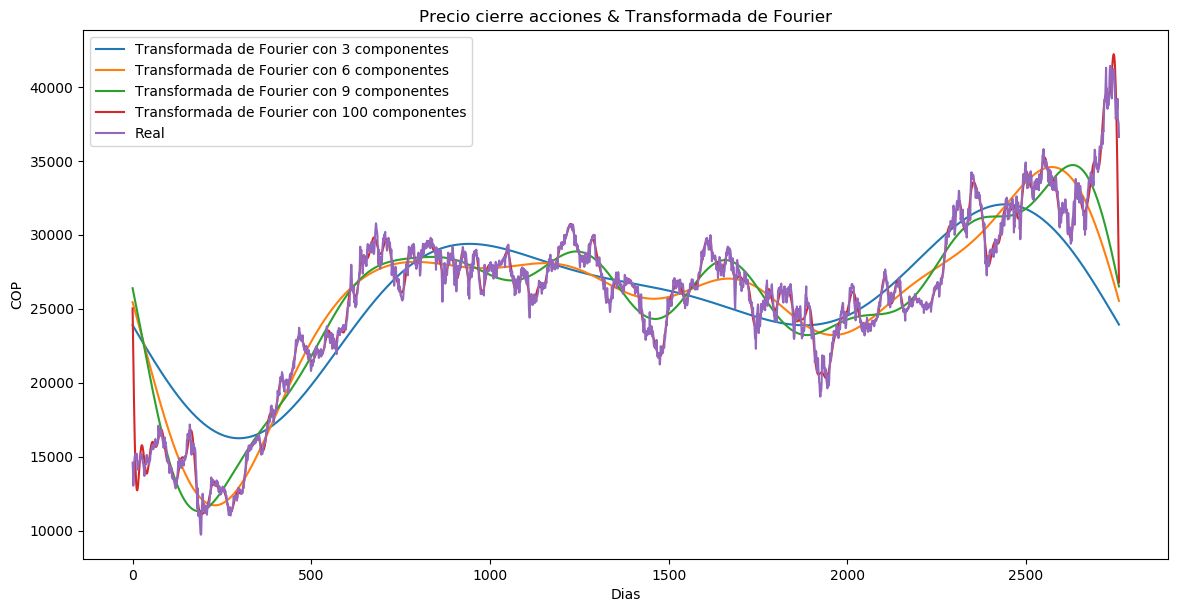

In [24]:
Fourier_list=[]
plt.figure(figsize=(14, 7), dpi=100)
fft_list = np.asarray(fourier_trasnform_df['fourier_trasnform'].tolist())
for num_ in [3, 6, 9, 100]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    plt.plot(np.fft.ifft(fft_list_m10), label='Transformada de Fourier con {} componentes'.format(num_))
    Fourier_list.append(fft_list_m10)
plt.plot(dataframe['Precio Cierre'].values,  label='Real')
plt.xlabel('Dias')
plt.ylabel('COP')
plt.title('Precio cierre acciones & Transformada de Fourier')
plt.legend()
plt.show()

In [25]:
np.fft.ifft(Fourier_list[0])

array([23894.44463393-2040.11960807j, 23853.50173487-2041.38946334j,
       23812.56356968-2042.56417193j, ..., 24017.29030721-2035.73977624j,
       23976.34006251-2037.29469869j, 23935.391124  -2038.75466532j])

In [26]:
dataframe['Fourier3']=np.fft.ifft(Fourier_list[0])
dataframe['Fourier6']=np.fft.ifft(Fourier_list[1])
dataframe['Fourier9']=np.fft.ifft(Fourier_list[2])
dataframe['Fourier100']=np.fft.ifft(Fourier_list[3])
dataframe

,Nemotecnico,fecha,Cantidad,Volumen,Precio Cierre,Precio Mayor,Precio Medio,Precio Menor,Variacion%,Variacion Absoluta,Fourier3,Fourier6,Fourier9,Fourier100
0,BCOLOMBIA,2008-01-17,451725,6708441780,14600,15060,14850.7206,14600,-2.67,-400,(23894.44463392922-2040.119608071797j),(25449.099585711483-659.209601762149j),(26392.40138248898-131.16412976656306j),(25025.810172609017-40.363509999612084j)
1,BCOLOMBIA,2008-01-18,333726,4831369460,14100,14740,14477.0544,14100,-3.42,-500,(23853.50173486786-2041.3894633398145j),(25361.576751724187-659.9189809984374j),(26273.121848335628-131.6598265723547j),(23296.42846041834-33.79826595116581j)
2,BCOLOMBIA,2008-01-21,517380,6748778840,13040,13200,13044.1433,13040,-7.52,-1060,(23812.563569681064-2042.564171933087j),(25273.89208531254-660.5053295908582j),(26153.429582001474-132.10029655782122j),(21635.032299420436-25.490227035315264j)
3,BCOLOMBIA,2008-01-22,886518,11979103280,13600,14200,13512.5325,12420,4.29,560,(23771.631281483835-2043.64367909988j),(25186.051343916883-660.9685382247167j),(26033.33966214024-132.48535496079117j),(20068.082999976024-15.867794152903102j)
4,BCOLOMBIA,2008-01-23,355748,4933362960,13900,14160,13867.5775,13100,2.21,300,(23730.70601360176-2044.6279345256794j),(25098.060304621005-661.308520542654j),(25912.867255115663-132.81484026236313j),(18619.20966341845-5.427144435159147j)
5,BCOLOMBIA,2008-01-24,396916,5781997880,14740,14740,14567.3086,14400,6.04,840,(23689.788909530882-2045.5168923355318j),(25009.924763536284-661.5252131607582j),(25792.027611475736-133.08861425465122j),(17308.503641143958+5.293353943476688j)
6,BCOLOMBIA,2008-01-25,341845,5142644400,15040,15220,15043.7900,14860,2.04,300,(23648.88111289754-2046.3105110961942j),(24921.65053518332-661.6185756803978j),(25670.83606240575-133.30656209877029j),(16151.941738276635+15.740902517598064j)
7,BCOLOMBIA,2008-01-28,353054,5284271860,15080,15260,14967.3191,14500,0.27,40,(23607.983767418085-2047.0087538180803j),(24833.24345187125-661.5885906957146j),(25549.308016161216-133.46859237302044j),(15160.958867115534+25.376777375791573j)
8,BCOLOMBIA,2008-01-29,410359,6270901640,15200,15340,15281.5014,15160,0.80,120,(23567.098016858738-2047.611587956927j),(24744.709363075006-661.4352637969014j),(25427.458954481805-133.5746371111988j),(14342.184869271934+33.704108256460614j)
9,BCOLOMBIA,2008-01-30,242406,3641014260,15100,15160,15020.3141,14900,-0.66,-100,(23526.22500499534-2048.1189854153913j),(24656.054134810158-661.1586235691414j),(25305.30442898711-133.62465183115816j),(13697.353670671962+40.29349947580292j)


## 7. ARIMA

Esta es una técnica de predicción de series de tiempo, sin embargo, sus salidas serán usadas como una característica más dentro de nuestro conjunto de datos. Los procedimientos realizados en esta sección, al igual que las transformadas de Fourier, son aplicados únicamente al precio de cierre de las acciones de BANCOLOMBIA.

In [27]:
df_cierre = dataframe[['fecha', 'Precio Cierre']]
df_cierre.head()

,fecha,Precio Cierre
0,2008-01-17,14600
1,2008-01-18,14100
2,2008-01-21,13040
3,2008-01-22,13600
4,2008-01-23,13900


In [28]:
df_cierre.set_index('fecha',inplace=True)
df_cierre['Precio Cierre'] = df_cierre['Precio Cierre'].astype(np.float64)
df_cierre.head()

data_FT = dataframe[['fecha', 'Precio Cierre']]
data_FT.head()

/opt/miniconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,fecha,Precio Cierre
0,2008-01-17,14600
1,2008-01-18,14100
2,2008-01-21,13040
3,2008-01-22,13600
4,2008-01-23,13900


In [29]:
from statsmodels.tsa.arima_model import ARIMA
from pandas import DataFrame
from pandas import datetime

serie_cierre = df_cierre['Precio Cierre']
model_arima = ARIMA(serie_cierre, order=(5, 1, 0))
model_arima_fit = model_arima.fit(disp=0)
print(model_arima_fit.summary())

/opt/miniconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/opt/miniconda/lib/python2.7/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:33: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import kalman_loglike
/opt/miniconda/lib/python2.7/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:33: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  from . import kalman_loglike
/opt/miniconda/lib/python2.7/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will res

                             ARIMA Model Results                              
Dep. Variable:        D.Precio Cierre   No. Observations:                 2760
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -20400.922
Method:                       css-mle   S.D. of innovations            392.564
Date:                Sun, 02 Jun 2019   AIC                          40815.844
Time:                        22:05:23   BIC                          40857.305
Sample:                    01-18-2008   HQIC                         40830.820
                         - 05-16-2019                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     8.0327      6.909      1.163      0.245      -5.508      21.573
ar.L1.D.Precio Cierre    -0.0524      0.019     -2.747      0.006      -0.090      -0.015
ar.L2.D.

/opt/miniconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  


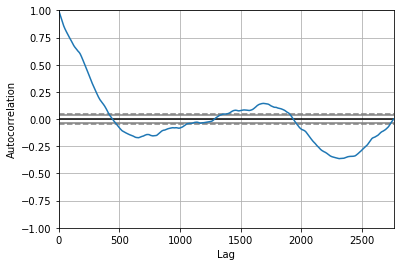

<Figure size 800x560 with 0 Axes>

In [30]:
from pandas.tools.plotting import autocorrelation_plot
autocorrelation_plot(serie_cierre)
plt.figure(figsize=(10, 7), dpi=80)
plt.show() 

In [31]:
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

X_arima = serie_cierre.values
size = int(len(X_arima) * 0.66)
train_arima, test_arima = X_arima[0:size], X_arima[size:len(X_arima)]
history_arima = [x for x in train_arima]
predictions_arima = list()
for i in range(len(test_arima)):
    model_arima = ARIMA(history_arima, order=(5,1,0))
    model_arima_fit = model_arima.fit(disp=0)
    output = model_arima_fit.forecast()
    yhat = output[0]
    predictions_arima.append(yhat)
    obs = test_arima[i]
    history_arima.append(obs)
    print i

/opt/miniconda/lib/python2.7/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

/opt/miniconda/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


847
848
849
850
851
852
853
854
855
856
857
858
859
860
861
862
863
864
865
866
867
868
869
870
871
872
873
874
875
876
877
878
879
880
881
882
883
884
885
886
887
888
889
890
891
892
893
894
895
896
897
898
899
900
901
902
903
904
905
906
907
908
909
910
911
912
913
914
915
916
917
918
919
920
921
922
923
924
925
926
927
928
929
930
931
932
933
934
935
936
937
938


In [32]:
error_arima = mean_squared_error(test_arima, predictions_arima)
print('Test MSE: %.3f' % error_arima)

Test MSE: 198358.351


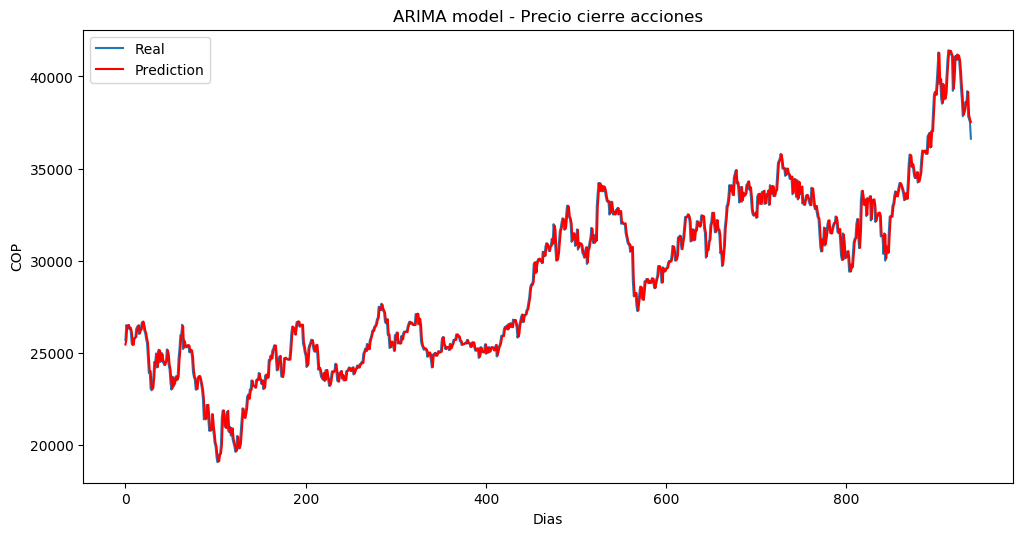

In [33]:
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test_arima, label='Real')
plt.plot(predictions_arima, color='red', label='Prediction')
plt.xlabel('Dias')
plt.ylabel('COP')
plt.title('ARIMA model - Precio cierre acciones')
plt.legend()
plt.show()

In [34]:
hist_and_preds_arima = [x for x in train_arima]
for i in range(len(predictions_arima)):
    hist_and_preds_arima.append(predictions_arima[i])
len(predictions_arima), len(train_arima)

(939, 1822)

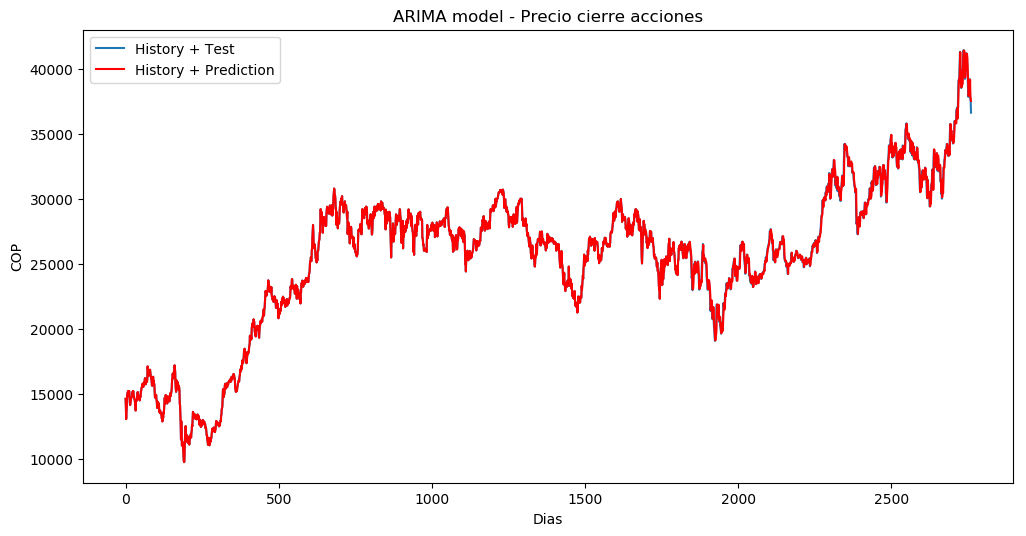

In [35]:
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(history_arima, label='History + Test')
plt.plot(hist_and_preds_arima, color='red', label='History + Prediction')
plt.xlabel('Dias')
plt.ylabel('COP')
plt.title('ARIMA model - Precio cierre acciones')
plt.legend()
plt.show()

In [36]:
len(hist_and_preds_arima)

2761

In [37]:
dataframe['ARIMA']=np.array(hist_and_preds_arima)
sub_df=dataframe[['fecha','Fourier3','Fourier6','Fourier9','Fourier100','ARIMA']]
sub_df

,fecha,Fourier3,Fourier6,Fourier9,Fourier100,ARIMA
0,2008-01-17,(23894.44463392922-2040.119608071797j),(25449.099585711483-659.209601762149j),(26392.40138248898-131.16412976656306j),(25025.810172609017-40.363509999612084j),14600.000000
1,2008-01-18,(23853.50173486786-2041.3894633398145j),(25361.576751724187-659.9189809984374j),(26273.121848335628-131.6598265723547j),(23296.42846041834-33.79826595116581j),14100.000000
2,2008-01-21,(23812.563569681064-2042.564171933087j),(25273.89208531254-660.5053295908582j),(26153.429582001474-132.10029655782122j),(21635.032299420436-25.490227035315264j),13040.000000
3,2008-01-22,(23771.631281483835-2043.64367909988j),(25186.051343916883-660.9685382247167j),(26033.33966214024-132.48535496079117j),(20068.082999976024-15.867794152903102j),13600.000000
4,2008-01-23,(23730.70601360176-2044.6279345256794j),(25098.060304621005-661.308520542654j),(25912.867255115663-132.81484026236313j),(18619.20966341845-5.427144435159147j),13900.000000
5,2008-01-24,(23689.788909530882-2045.5168923355318j),(25009.924763536284-661.5252131607582j),(25792.027611475736-133.08861425465122j),(17308.503641143958+5.293353943476688j),14740.000000
6,2008-01-25,(23648.88111289754-2046.3105110961942j),(24921.65053518332-661.6185756803978j),(25670.83606240575-133.30656209877029j),(16151.941738276635+15.740902517598064j),15040.000000
7,2008-01-28,(23607.983767418085-2047.0087538180803j),(24833.24345187125-661.5885906957146j),(25549.308016161216-133.46859237302044j),(15160.958867115534+25.376777375791573j),15080.000000
8,2008-01-29,(23567.098016858738-2047.611587956927j),(24744.709363075006-661.4352637969014j),(25427.458954481805-133.5746371111988j),(14342.184869271934+33.704108256460614j),15200.000000
9,2008-01-30,(23526.22500499534-2048.1189854153913j),(24656.054134810158-661.1586235691414j),(25305.30442898711-133.62465183115816j),(13697.353670671962+40.29349947580292j),15100.000000


In [38]:
temp=pd.merge(temp, sub_df, how='left', left_on=['fecha'], right_on=['fecha']).sort_values('fecha')
temp

,fecha,Cantidad,Volumen,BCOLOMBIA,Precio Mayor,Precio Medio,Precio Menor,Variacion,Variacion Absoluta,COLCAP,...,upper_band,lower_band,ema,momentum,log_momentum,Fourier3,Fourier6,Fourier9,Fourier100,ARIMA
0,2008-02-14,486958.0,7.207594e+09,14720.0,14860.0,14801.2637,14720.0,0.14,20.0,928.67,...,15726.977202,13393.022798,14696.852167,14719.0,9.596894,(23077.789637153455-2047.3979549256874j),(23674.54376464905-650.0080572702924j),(23945.950802950483-130.48762485511594j),(14657.716198668959-17.699895836807713j),14720.000000
1,2008-02-15,177200.0,2.612417e+09,14800.0,14900.0,14742.7603,14600.0,0.54,80.0,929.63,...,15720.543495,13418.504124,14765.617389,14799.0,9.602315,(23037.158652749607-2046.7595404533001j),(23584.897571540427-648.2622367874701j),(23821.364189115026-129.87035380620222j),(14978.102565593203-27.117836725350017j),14800.000000
2,2008-02-18,41671.0,6.194736e+08,14980.0,14980.0,14865.8208,14800.0,1.22,180.0,944.25,...,15510.878696,13711.978447,14908.539130,14979.0,9.614404,(22996.555258700115-2046.0257290134211j),(23495.20771469211-646.3955588620169j),(23696.67897550279-129.19860655995564j),(15256.495459806114-35.137456566074945j),14980.000000
3,2008-02-20,153372.0,2.285442e+09,15000.0,15100.0,14901.2959,14740.0,-1.06,-160.0,941.38,...,15452.079916,13957.443893,14969.513043,14999.0,9.615739,(22915.435799819246-2044.2720564841288j),(23315.721140685317-642.3010451912403j),(23447.077339126874-127.69283330865031j),(15646.305600843376-45.421045734432305j),15000.000000
4,2008-02-21,535243.0,8.086449e+09,15200.0,15200.0,15107.9949,15000.0,1.33,200.0,944.38,...,15433.445575,14128.459187,15123.171014,15199.0,9.628985,(22874.922012541512-2043.252277131255j),(23225.936505762536-640.0739727982141j),(23322.193243659567-126.85943892428568j),(15745.908216915952-47.15474565573794j),15200.000000
5,2008-02-22,186042.0,2.795472e+09,15000.0,15140.0,15026.0261,15000.0,-1.32,-200.0,940.05,...,15489.048291,14177.618376,15041.057005,14999.0,9.615739,(22834.440370645185-2042.1372642801648j),(23136.13237027698-637.7275695247697j),(23197.275195514874-125.97283131899569j),(15779.898548926501-46.45692885898407j),15000.000000
6,2008-02-26,274246.0,4.040685e+09,14700.0,14840.0,14733.7975,14660.0,-1.08,-160.0,938.49,...,15482.707475,14180.149668,14813.685668,14699.0,9.595535,(22753.578070532796-2039.6217503971404j),(22956.489821939755-632.6785422898901j),(22947.40195658023-124.04148621772771j),(15664.180618188086-38.034200565840486j),14700.000000
7,2008-02-27,186037.0,2.721296e+09,14580.0,14700.0,14627.7157,14500.0,-0.82,-120.0,935.15,...,15457.318449,14161.729170,14657.895223,14579.0,9.587337,(22713.19968416003-2038.2213666102496j),(22866.663531550854-629.9768596335098j),(22822.479118245257-122.99755885534117j),(15527.914921275058-30.743603884922667j),14580.000000
8,2008-02-28,555937.0,8.034766e+09,14480.0,14520.0,14452.6555,14260.0,-0.69,-100.0,931.03,...,15414.073306,14147.831456,14539.298408,14479.0,9.580455,(22672.857986775234-2036.7259838097411j),(22776.84198422669-627.1577285313463j),(22697.58702466905-121.9020381994115j),(15351.976077757765-21.867724836749158j),14480.000000
9,2008-02-29,641099.0,9.207790e+09,14260.0,14560.0,14362.5082,14260.0,-1.52,-220.0,914.90,...,15385.582094,14086.798858,14353.099469,14259.0,9.565144,(22632.554112195263-2035.135671693574j),(22687.031248579468-624.2216745623285j),(22572.741830033712-120.75538378359317j),(15147.710633037095-11.864244784950017j),14260.000000


In [39]:
temp.columns

Index([             u'fecha',           u'Cantidad',            u'Volumen',
                u'BCOLOMBIA',       u'Precio Mayor',       u'Precio Medio',
             u'Precio Menor',          u'Variacion', u'Variacion Absoluta',
                   u'COLCAP',             u'BOGOTA',          u'OCCIDENTE',
                  u'POPULAR',            u'BBVACOL',                u'BVC',
               u'PROTECCION',                u'ma7',               u'ma21',
                    u'26ema',              u'12ema',               u'MACD',
                     u'20sd',         u'upper_band',         u'lower_band',
                      u'ema',           u'momentum',       u'log_momentum',
                 u'Fourier3',           u'Fourier6',           u'Fourier9',
               u'Fourier100',              u'ARIMA'],
      dtype='object')

In [40]:
!pip install xlwt

You are using pip version 9.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


Finalmente, contamos con una dataset de 31 características y 2738 registros. A continuación, exportamos el dataframe "temp", el cual nos servirá con insumo para el entrenamiento de los distintos modelos generados a lo largo de este proyecto.

In [41]:
temp.to_excel("./data/Dataset.xls") 